In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [254]:
DATA_PATH = '../data/games_info.csv'
df = pd.read_csv(DATA_PATH)

In [259]:
df.head()

,Title,Release date,Platform,Other platforms,Publisher,Developer,Genres,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews
0,The Legend of Zelda: Ocarina of Time,"Nov 23, 1998",Nintendo 64,NaN,Nintendo,Nintendo,"Action Adventure,Fantasy",E,1 Player,99.0,22,9.1,7359
1,Tony Hawk's Pro Skater 2,"Sep 20, 2000",PlayStation,"iPhone/iPad,PC",Activision,Neversoft Entertainment,"Sports,Alternative,Skateboarding",T,1-2,98.0,19,7.4,845
2,Grand Theft Auto IV,"Apr 29, 2008",PlayStation 3,"PC,Xbox 360",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,64,7.8,4735
3,SoulCalibur,"Sep 8, 1999",Dreamcast,NaN,Namco,Namco,"Action,Fighting,3D",T,1-2,98.0,24,8.4,394
4,Grand Theft Auto IV,"Apr 29, 2008",Xbox 360,"PC,PlayStation 3",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,86,8.0,3671


In [260]:
df.isnull().sum()

Title                         0
Release date                  0
Platform                      0
Other platforms             480
Publisher                     0
Developer                     1
Genres                        0
Rating                       87
Number of players           218
Metascore                     0
Number of critic reviews      0
User Score                    0
Number of user reviews        0
dtype: int64

In [54]:
df['Rating'] = df['Rating'].fillna('E')
df['Release date'] = df['Release date'].astype('str').apply(lambda x: x[-4:]).astype(int)

list_n_company = []
df['Developer'] = df['Developer'].fillna("Self Developer")
for i in range(len(df)):
    n_company = len(df['Developer'][i].split(','))
    list_n_company.append(n_company)
df['Number of companies'] = list_n_company

genres_df = df['Genres'].str.split(',', expand=True).apply(pd.value_counts, axis=1).fillna(0)
for col in genres_df:
    genres_df[col] = genres_df[col].astype(bool)

df = pd.concat([df, genres_df], axis=1, join='inner')

df['Number of players'] = df['Number of players'].fillna(1)
def handle_n_players(x):
    if x in ['Massively Multiplayer', 'Online Multiplayer']:
        return str(100)

    tokens = x.replace('+', ' ').replace('-', ' ').split()
    max_player = 1
    for token in tokens:
        if token.isdigit():
            max_player = max(max_player, int(token))
    return str(max_player)

df['Number of players'] = df['Number of players'].astype('str').apply(lambda x: handle_n_players(x)).astype(int)
df = df.drop(columns=['Genres', 'Other platforms',  'Title'])

for data in df.columns:
    if df[data].dtype=='object':
        l_en = LabelEncoder()  # converting line
        df[data] = l_en.fit_transform(df[data]) # converting line ##important

In [55]:
df.head()

,Release date,Platform,Publisher,Developer,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews,...,Tycoon,Vehicle,Vertical,Virtual,Virtual Life,Visual Novel,WWII,Wargame,Western-Style,Wrestling
0,1998,5,127,266,1,1,99.0,22,9.1,7359,...,False,False,False,False,False,False,False,False,False,False
1,2000,8,13,259,5,2,98.0,19,7.4,845,...,False,False,False,False,False,False,False,False,False,False
2,2008,10,151,329,4,1,98.0,64,7.8,4735,...,False,False,False,False,False,False,False,False,False,False
3,1999,2,121,252,5,2,98.0,24,8.4,394,...,False,False,False,False,False,False,False,False,False,False
4,2008,18,151,329,4,1,98.0,86,8.0,3671,...,False,False,False,False,False,False,False,False,False,False


In [56]:
def classify_userscore(x):
    if x < 8.0:
        return 0
    # if x >= 7.0 and x < 8.0:
    #     return 1
    if x >= 8.0:
        return 1

df['User Score'] = df['User Score'].apply(lambda x: classify_userscore(x)).astype(int)

In [57]:
df.dtypes

Release date     int32
Platform         int32
Publisher        int32
Developer        int32
Rating           int32
                 ...  
Visual Novel      bool
WWII              bool
Wargame           bool
Western-Style     bool
Wrestling         bool
Length: 139, dtype: object

In [58]:
df['User Score'].value_counts(normalize=True)

1    0.61749
0    0.38251
Name: User Score, dtype: float64

In [59]:
#User score is the target so we will spilt with it
x = df.drop(['User Score'] , axis = 1).values
y= df['User Score'].values
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)

In [60]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
r, c = x_train.shape
r2 ,c2 = x_test.shape
print (f"x_train = {r} and y_train = {y_train.shape} ")
print (f"x_test = {r2} and y_test = {y_test.shape} ")

x_train = 1123 and y_train = (1123,) 
x_test = 375 and y_test = (375,) 


### 1. Logistic Regression

In [162]:
lr = LogisticRegression()

In [176]:
list_C = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

tuning_dict = dict(
    C = list_C,
    max_iter = [2000]
)

In [177]:
# Khởi tạo grid search cross validation
search = GridSearchCV(lr, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [178]:
best_hp.best_params_

{'C': 2, 'max_iter': 2000}

In [185]:
lr_model_tuning = LogisticRegression(C = 2, max_iter=2000)
lr_model_tuning.fit(x_train , y_train)

LogisticRegression(C=2, max_iter=2000)

In [186]:
lr_model_tuning.score(x_train , y_train)

0.7827248441674087

In [187]:
lr_model_tuning.score(x_test, y_test)

0.7306666666666667

In [188]:
lr_model_tuning.intercept_

array([1.0697912])

In [189]:
Y_pred = lr_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,1
2,1,0
3,0,0
4,1,1
5,1,0
6,1,1
7,1,1
8,1,1
9,0,1


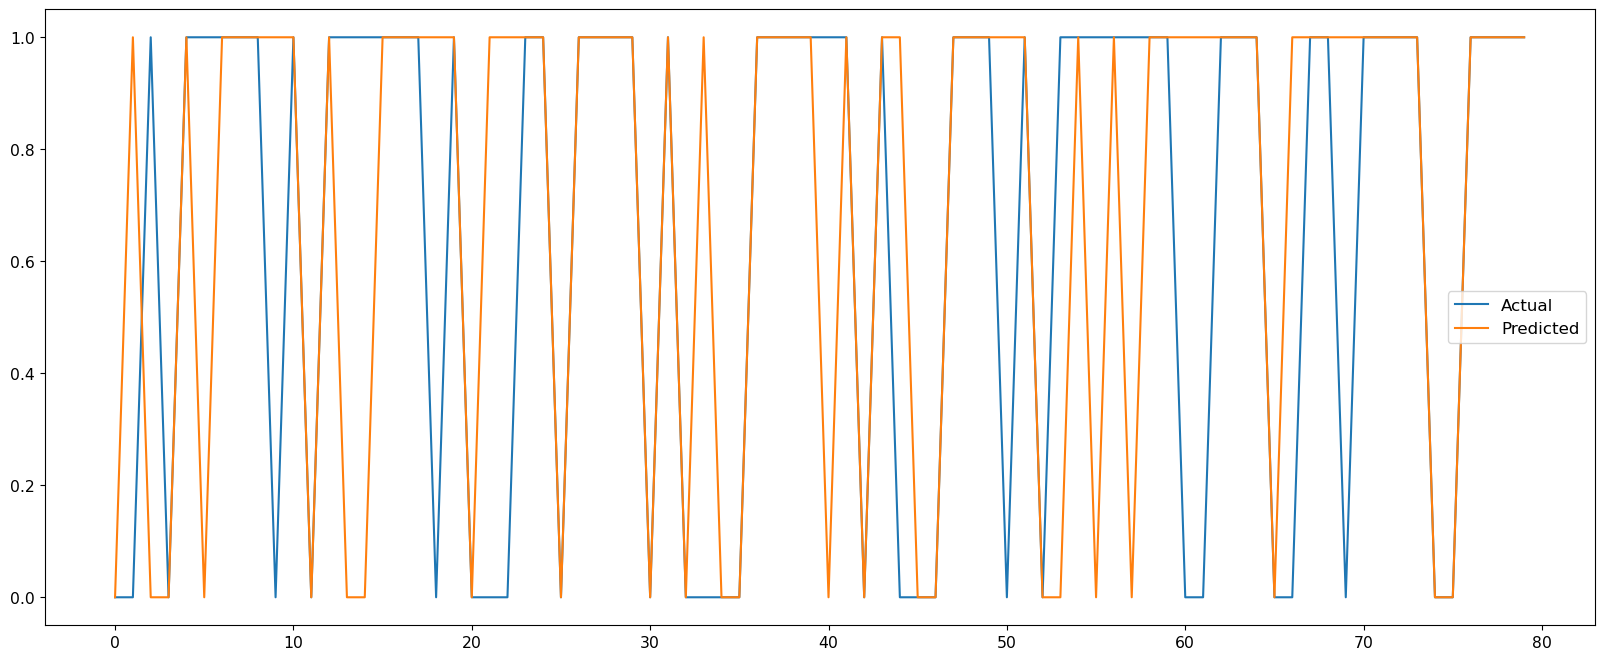

In [190]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 2. K Neighbors Classifier

In [236]:
knn = KNeighborsClassifier()

In [244]:
k_range = [8, 10, 12, 14, 16]

tuning_dict = dict(
    n_neighbors = k_range,
)

In [252]:
# Khởi tạo grid search cross validation
search = GridSearchCV(knn, tuning_dict, verbose = 1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [253]:
best_hp.best_params_

{'n_neighbors': 8}

In [247]:
best_hp.best_score_

0.698079962073325

In [249]:
knn_model_tuning = KNeighborsClassifier(n_neighbors = 8)
knn_model_tuning.fit(x_train , y_train)

KNeighborsClassifier(n_neighbors=8)

In [250]:
knn_model_tuning.score(x_train , y_train)

0.7889581478183437

In [251]:
knn_model_tuning.score(x_test, y_test)

0.7253333333333334

In [102]:
Y_pred = knn_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,1
2,1,0
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,0,1


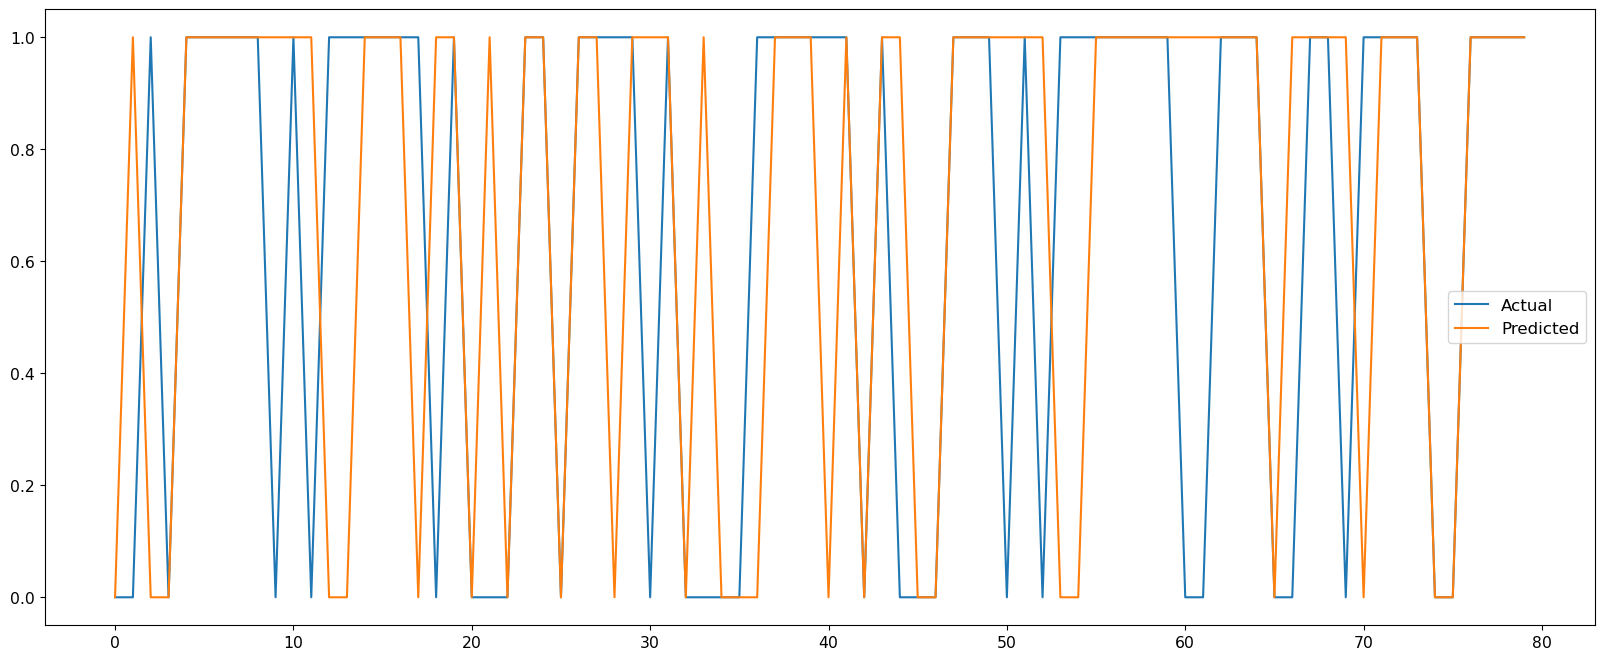

In [103]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 3. Decision Tree Classifier

In [156]:
dt = DecisionTreeClassifier()

In [155]:
list_criterion = ['gini', 'entropy']

list_max_features = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

list_max_depth = [5, 10, 15, 20, 25, 30]

list_min_samples_split = [2, 4, 6, 8, 10, 12, 14, 16 , 18, 20, 22, 24]

list_min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

tuning_dict = dict(
    criterion = list_criterion, 
    max_features = list_max_features,
    max_depth = list_max_depth, 
    min_samples_split = list_min_samples_split,
    min_samples_leaf = list_min_samples_leaf
)

In [157]:
# Khởi tạo grid search cross validation
search = GridSearchCV(dt, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 19800 candidates, totalling 99000 fits


In [158]:
best_hp.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 70,
 'min_samples_leaf': 18,
 'min_samples_split': 2}

In [159]:
dt_model_tuning = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 25,
    max_features = 70,
    min_samples_leaf = 18,
    min_samples_split = 2
)
dt_model_tuning.fit(x_train , y_train)

DecisionTreeClassifier(max_depth=25, max_features=70, min_samples_leaf=18)

In [160]:
dtt = dt_model_tuning.score(x_train , y_train)
dtt

0.7569011576135352

In [161]:
dts = dt_model_tuning.score(x_test , y_test)
dts

0.7146666666666667